In [68]:
#1.  dataset <- transaction.csv, dan tampilkan
import pandas as pd
import chardet
# Fungsi untuk membaca file CSV dengan deteksi encoding
def read_csv_file(filename):
    try:
        with open(filename, 'rb') as file:
            raw_data = file.read()
            encoding = chardet.detect(raw_data)['encoding']
        
        data = pd.read_csv(filename, encoding=encoding)
        
        if data.empty:
            print(f"Warning: {filename} is empty")
        else:
            print(f"Dataset '{filename}' berhasil dibaca. Berikut ini adalah isi dataset:")
            print(data.head())
        
        return data
    except FileNotFoundError:
        print(f"Warning: {filename} not found")
        return None
    except Exception as e:
        print(f"Error reading {filename}: {str(e)}")
        return None

filename = 'transaction.csv' 
transaction_data = read_csv_file(filename)

if transaction_data is not None:
    pd.set_option("display.max_rows", None)
    pd.set_option("display.max_columns", None)  
    print(transaction_data)

Dataset 'transaction.csv' berhasil dibaca. Berikut ini adalah isi dataset:
   InvoiceNo  StockCode  Qty      InvoiceDate  CustomerID  Country
0     537626      22725  830  12/7/2010 14:57       12347  Iceland
1     537626      22729  948  12/7/2010 14:57       12347  Iceland
2     537626      22195  695  12/7/2010 14:57       12347  Iceland
3     542237      22725  636  1/26/2011 14:30       12347  Iceland
4     542237      22729  536  1/26/2011 14:30       12347  Iceland
       InvoiceNo  StockCode  Qty       InvoiceDate  CustomerID  \
0         537626      22725  830   12/7/2010 14:57       12347   
1         537626      22729  948   12/7/2010 14:57       12347   
2         537626      22195  695   12/7/2010 14:57       12347   
3         542237      22725  636   1/26/2011 14:30       12347   
4         542237      22729  536   1/26/2011 14:30       12347   
5         542237      47559  919   1/26/2011 14:30       12347   
6         542237      21154  803   1/26/2011 14:30       1234

In [69]:
#2. keywords <- lakukan Tokenizing, Filtering dan Stemming/Tagging pada data
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Inisialisasi Sastrawi stemmer dan stopword remover
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()
stopword_factory = StopWordRemoverFactory()
stopwords = stopword_factory.get_stop_words()

# Fungsi untuk preprocessing text
def preprocess_text(text):
    if not isinstance(text, str):
        print(f"Warning: Input text is not string: {type(text)}")
        return []
    if not text.strip():
        print("Warning: Input text is empty")
        return []
    
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords]
    tokens = [stemmer.stem(word) for word in tokens]
    
    if not tokens:
        print("Warning: No tokens generated after preprocessing")
    return tokens


In [70]:
#3. scores <- lakukan penghitungan TF dan hilangkan keyword yang mempunyai score TF dibawah 50% dari score tertinggi TF, dan tampilkan
# Fungsi untuk menghitung TF
def calculate_tf(documents):
    tf_scores = {}
    for doc_id, tokens in documents.items():
        tf_dict = {}
        for token in tokens:
            tf_dict[token] = tf_dict.get(token, 0) + 1
        if tf_dict:
            tf_scores[doc_id] = tf_dict
    return tf_scores

# Fungsi untuk memfilter TF rendah
def filter_low_tf(tf_scores, threshold=0.5):
    all_values = [score for doc_scores in tf_scores.values() for score in doc_scores.values()]
    max_tf = max(all_values) if all_values else 0
    threshold_value = max_tf * threshold
    
    filtered_tf = {
        doc_id: {word: score for word, score in scores.items() if score >= threshold_value}
        for doc_id, scores in tf_scores.items()
    }
    return filtered_tf


In [71]:
#4. querylist <- masukkan query “pertumbuhan ekonomi, perkembangan pasar dan pergerakan harga saham”
# Fungsi untuk preprocessing query
def preprocess_query(query):
    tokens = preprocess_text(query)
    return tokens


In [72]:
#5. rankdocs <- lakukan pencarian dari querylist terhadap scores masing-masing data, dan ambil 10 data yang mempunyai total scores tertinggi
# Fungsi untuk menghitung similarity dan ranking dokumen
def rank_documents(query_tokens, tf_scores):
    rankings = {}
    for doc_id, tf_dict in tf_scores.items():
        score = sum(tf_dict.get(token, 0) for token in query_tokens)
        if score > 0:
            rankings[doc_id] = score
    
    sorted_docs = sorted(rankings.items(), key=lambda x: x[1], reverse=True)[:10]
    return dict(sorted_docs)


In [ ]:
#6. label <- baca file label.csv
import pandas as pd

# Load labels
try:
    labels_df = pd.read_csv('label.csv', header=None, names=['document_id', 'category'])
    labels = dict(zip(labels_df['document_id'], labels_df['category']))
except FileNotFoundError:
    print("Warning: Label file not found")
    labels = {}

In [ ]:
#7. recall, precision <- hitunglah recall dan precision dari rankdocs dimulai dari ranking 1 sampai ranking 10,
# Fungsi untuk menghitung recall dan precision
def calculate_metrics(rankdocs, labels, query_category):
    true_positives = sum(1 for doc_id in rankdocs if labels.get(f'data{doc_id}') == query_category)
    total_relevant = sum(1 for category in labels.values() if category == query_category)
    
    precision = true_positives / len(rankdocs) if len(rankdocs) > 0 else 0
    recall = true_positives / total_relevant if total_relevant > 0 else 0
    
    return recall, precision

In [ ]:
#8. Visualisasikan grafik recall dan precision
import matplotlib.pyplot as plt

# Fungsi untuk plot metrics
def plot_metrics(recall_values, precision_values):
    ranks = range(1, len(recall_values) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(ranks, recall_values, marker='o', label='Recall')
    plt.plot(ranks, precision_values, marker='x', label='Precision')
    plt.xlabel('Top K Documents')
    plt.ylabel('Score')
    plt.title('Recall and Precision at Different Top-K Levels')
    plt.legend()
    plt.grid(True)
    plt.show()

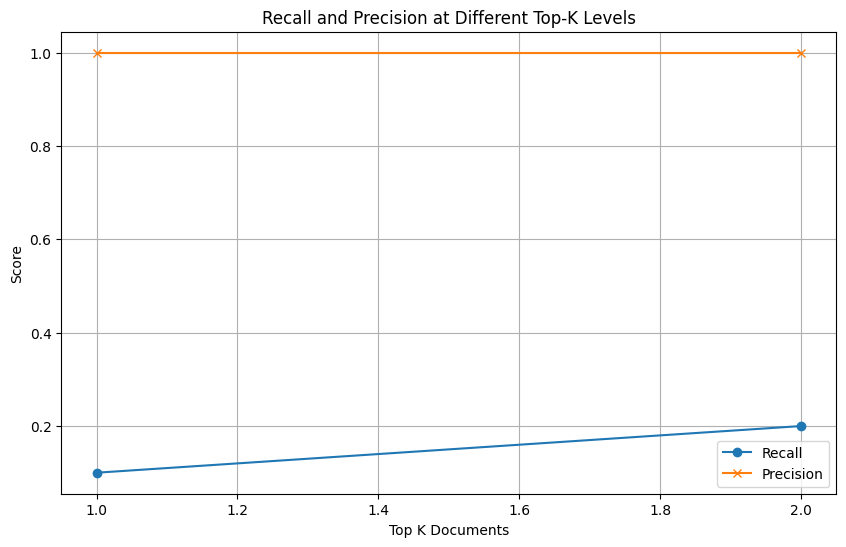

In [76]:
# Main execution
documents = {}
for i in range(1, 51):
    content = read_txt_file(i)
    if content.strip():
        tokens = preprocess_text(content)
        if tokens:
            documents[i] = tokens

# Menghitung TF dan Memfilter berdasarkan Threshold
tf_scores = calculate_tf(documents)
filtered_tf = filter_low_tf(tf_scores)

# Proses Query
query = "pertumbuhan ekonomi, perkembangan pasar dan pergerakan harga saham"
query_tokens = preprocess_query(query)

# Ranking Dokumen
rankdocs = rank_documents(query_tokens, filtered_tf)

# Menghitung Recall dan Precision
recall_values = []
precision_values = []
for k in range(1, min(11, len(rankdocs) + 1)):
    top_k_docs = dict(list(rankdocs.items())[:k])
    recall, precision = calculate_metrics(top_k_docs, labels, "ekonomi")
    recall_values.append(recall)
    precision_values.append(precision)

# Visualisasi Grafik
if recall_values and precision_values:
    plot_metrics(recall_values, precision_values)
else:
    print("No metrics to plot")
